In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Load the dataset and check first five rows, shape, column names and info

In [2]:
df=pd.read_csv("C:/Users/arnav/Desktop/Python_projects/EDA/NLP/data/spam_ham_dataset.csv")
df.shape,df.columns,df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


((5171, 4),
 Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object'),
 None)

# Check target distribution

In [3]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

# Drop unnecessary columns and check for NaN values

In [4]:
df=df.drop(columns=['Unnamed: 0'])
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [5]:
df

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


In [6]:
df['text']=df['text'].str.replace(r'^Subject:\s*','',regex=True)


In [7]:
df['char_len']=df['text'].str.len()
df['word_len']=df['text'].str.split().apply(len)
df.groupby('label')[['char_len','word_len']].describe().T

label                    ham          spam
char_len count   3672.000000   1499.000000
         mean     968.008170   1214.174116
         std     1382.827493   1826.007379
         min        9.000000      0.000000
         25%      222.750000    274.000000
         50%      521.000000    567.000000
         75%     1218.250000   1244.500000
         max    32249.000000  22064.000000
word_len count   3672.000000   1499.000000
         mean     224.214325    233.077385
         std      332.139170    345.413339
         min        1.000000      0.000000
         25%       49.000000     53.000000
         50%      122.000000    113.000000
         75%      292.000000    241.500000
         max     8861.000000   3961.000000

In [8]:
df.groupby('label')[['char_len','word_len']].mean()

,char_len,word_len
label,,
ham,968.008170,224.214325
spam,1214.174116,233.077385


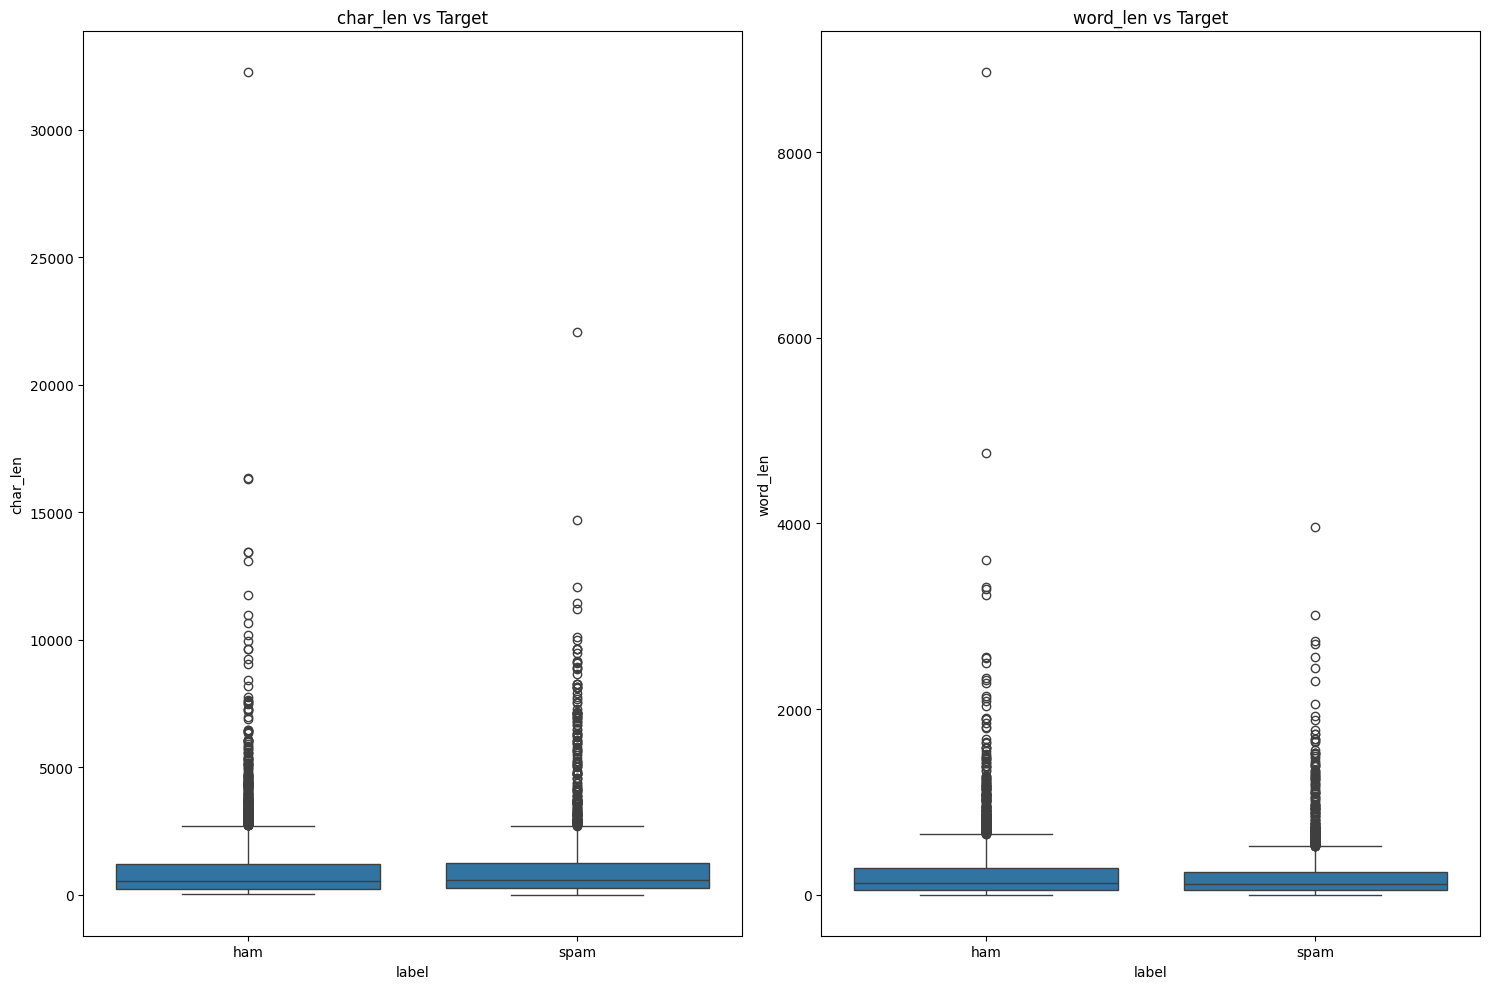

In [9]:
fig,axes=plt.subplots(1,2, figsize=(15,10))

parameters=["char_len","word_len"]

for i,c in enumerate(parameters):
    sns.boxplot(data=df,y=c,x='label',ax=axes[i])
    axes[i].set_title(f'{c} vs Target')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, n=20, ngram_range=(1,1)):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]


In [11]:
spam_text = df[df['label']=='spam']['text']
ham_text  = df[df['label']=='ham']['text']


In [12]:
top_spam_uni = top_ngrams(spam_text, n=20)
top_spam_uni


[('com', np.int64(992)),
 ('http', np.int64(983)),
 ('company', np.int64(728)),
 ('www', np.int64(587)),
 ('00', np.int64(585)),
 ('information', np.int64(520)),
 ('font', np.int64(515)),
 ('td', np.int64(504)),
 ('statements', np.int64(476)),
 ('email', np.int64(474)),
 ('price', np.int64(471)),
 ('new', np.int64(432)),
 ('nbsp', np.int64(418)),
 ('height', np.int64(362)),
 ('time', np.int64(361)),
 ('99', np.int64(321)),
 ('free', np.int64(313)),
 ('pills', np.int64(311)),
 ('size', np.int64(306)),
 ('width', np.int64(306))]

In [13]:
top_ham_uni = top_ngrams(ham_text, n=20)
top_ham_uni


[('ect', np.int64(13897)),
 ('hou', np.int64(7281)),
 ('enron', np.int64(6555)),
 ('2000', np.int64(4308)),
 ('gas', np.int64(2861)),
 ('deal', np.int64(2789)),
 ('subject', np.int64(2731)),
 ('com', np.int64(2717)),
 ('meter', np.int64(2459)),
 ('cc', np.int64(2359)),
 ('pm', np.int64(2325)),
 ('hpl', np.int64(2318)),
 ('2001', np.int64(2024)),
 ('daren', np.int64(1901)),
 ('000', np.int64(1880)),
 ('00', np.int64(1819)),
 ('10', np.int64(1815)),
 ('thanks', np.int64(1813)),
 ('01', np.int64(1723)),
 ('corp', np.int64(1710))]

In [14]:
top_spam_bi = top_ngrams(spam_text, n=20, ngram_range=(2,2))
top_spam_bi


[('http www', np.int64(409)),
 ('nbsp nbsp', np.int64(295)),
 ('computron com', np.int64(195)),
 ('href http', np.int64(175)),
 ('looking statements', np.int64(172)),
 ('src http', np.int64(157)),
 ('www computron', np.int64(152)),
 ('forward looking', np.int64(142)),
 ('http 69', np.int64(139)),
 ('69 63', np.int64(139)),
 ('63 161', np.int64(139)),
 ('td td', np.int64(134)),
 ('investment advice', np.int64(118)),
 ('font size', np.int64(115)),
 ('td tr', np.int64(111)),
 ('tr td', np.int64(94)),
 ('161 44', np.int64(92)),
 ('align center', np.int64(91)),
 ('windows xp', np.int64(83)),
 ('duty free', np.int64(82))]

In [15]:
top_ham_bi = top_ngrams(ham_text, n=20, ngram_range=(2,2))
top_ham_bi


[('hou ect', np.int64(7226)),
 ('ect ect', np.int64(6339)),
 ('enron enron', np.int64(1434)),
 ('ect cc', np.int64(1391)),
 ('corp enron', np.int64(1214)),
 ('cc subject', np.int64(1094)),
 ('let know', np.int64(982)),
 ('daren farmer', np.int64(933)),
 ('enron com', np.int64(831)),
 ('ect subject', np.int64(730)),
 ('farmer hou', np.int64(563)),
 ('attached file', np.int64(502)),
 ('original message', np.int64(437)),
 ('000 mmbtu', np.int64(423)),
 ('000 enron', np.int64(379)),
 ('2000 10', np.int64(366)),
 ('pec pec', np.int64(357)),
 ('teco tap', np.int64(333)),
 ('enron cc', np.int64(313)),
 ('ami chokshi', np.int64(308))]

In [16]:
df.isna().sum(),df.duplicated().sum()


(label        0
 text         0
 label_num    0
 char_len     0
 word_len     0
 dtype: int64,
 np.int64(178))

In [17]:
df=df.drop_duplicates()

In [18]:
df[df['text'].str.strip()==''].shape


(1, 5)

In [19]:
df = df[df['char_len'] > 0]


In [20]:
df[df['text'].str.strip()==''].shape

(0, 5)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4992 entries, 0 to 5170
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4992 non-null   object
 1   text       4992 non-null   object
 2   label_num  4992 non-null   int64 
 3   char_len   4992 non-null   int64 
 4   word_len   4992 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 234.0+ KB


In [22]:
numeric_cols = ['char_len','word_len']
X = df[['text'] + numeric_cols]         
y = df['label_num']    

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,2),
                                  min_df=1,       # <= change to 2 if you like
                                  max_df=0.95,
                                  stop_words='english',
                                  max_features=20000),
         'text'),
        ('num', 'passthrough', numeric_cols)
    ], remainder='drop'
)


In [29]:
models={
    "LR":Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', LogisticRegression(max_iter=5000))]),

    "MNB":Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', MultinomialNB())
    ])
}

In [30]:
for name, model in models.items():
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print(f"{name} classification_report:\n", classification_report(y_test, y_pred))
    print(f"{name} confusion_matrix:\n", confusion_matrix(y_test, y_pred))

LR classification_report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       707
           1       0.95      0.97      0.96       292

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999

LR confusion_matrix:
 [[691  16]
 [ 10 282]]
MNB classification_report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       707
           1       0.94      0.79      0.86       292

    accuracy                           0.92       999
   macro avg       0.93      0.88      0.90       999
weighted avg       0.92      0.92      0.92       999

MNB confusion_matrix:
 [[692  15]
 [ 62 230]]


In [31]:
param_distributions={
    "LR": {
    'clf__C': np.logspace(-3, 3, 20),
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
    },
    "MNB": {
    'clf__alpha': np.linspace(0.01, 2, 50),
    'clf__fit_prior': [True, False]
    },
}

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"\n===== Running RandomizedSearchCV for {name} =====")

    rsearch = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=10,              # increase for deeper search
        scoring="f1_macro",
        cv=cv,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    rsearch.fit(X_train, y_train)

    # Store results
    results[name] = rsearch

    print(f"Best Params for {name}: {rsearch.best_params_}")
    print(f"Best CV Score (F1): {rsearch.best_score_}")

    # Evaluate on test set
    y_pred = rsearch.predict(X_test)
    y_proba = rsearch.predict_proba(X_test)[:,1]

    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("ROC-AUC:", roc_auc_score(y_test, y_proba))



===== Running RandomizedSearchCV for LR =====
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for LR: {'clf__solver': 'liblinear', 'clf__penalty': 'l2', 'clf__C': np.float64(233.57214690901213)}
Best CV Score (F1): 0.9852106829556483

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       707
           1       0.97      0.99      0.98       292

    accuracy                           0.99       999
   macro avg       0.98      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999

Confusion Matrix:
[[698   9]
 [  3 289]]
ROC-AUC: 0.9985032260564608

===== Running RandomizedSearchCV for MNB =====
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Params for MNB: {'clf__fit_prior': True, 'clf__alpha': np.float64(0.01)}
Best CV Score (F1): 0.9515999120676966

Test Classification Report:
              precision    recall  f1-score   support

     

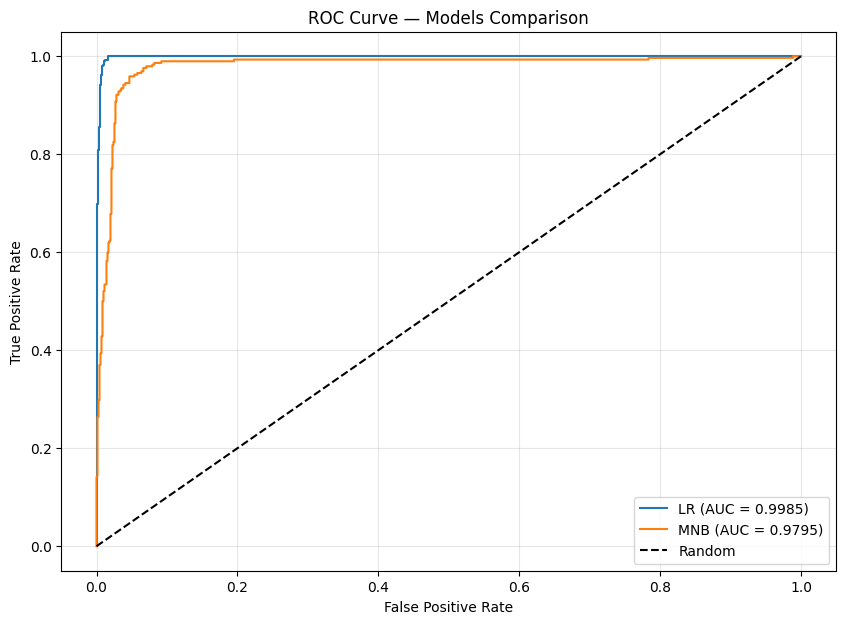

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

for name in results.keys():
    model = results[name].best_estimator_
    y_proba = model.predict_proba(X_test)[:,1]

    # Compute ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f"{name.upper()} (AUC = {roc_auc:.4f})")

# Random classifier line
plt.plot([0,1], [0,1], 'k--', label="Random")

plt.title("ROC Curve — Models Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
